# GleanerIO SHACL processor

## About

Ted Habberman presented to the CDF on ISO metadata analysis.  I have been exploring some approaches to accessing the FAIR Digital Object server that is part of the standard setup supporting GeoCODES and other groups.  Leveraging Python Dask and S3 Boto it is easy to access these object stores in a highly performant manner.  

In addition to DASK there is S3SELECT as well as SPARQL calls on objects and triplestores.  

## Notes

Curious above local context file reading when doing lots of calls.  PyLD seems to know to do caching but not sure how it could in a Dask based pattern.

May need to explore approach to read local files for context like

## Imports


In [2]:
import dask
import boto3
import pandas as pd
import json
import s3fs
import kglab
import seaborn as sns
from rdflib import Graph  #, plugin
import getpass
import plotly.express as px

## Set up Dask client

In [3]:
from dask.distributed import Client    #, progress
client = Client(threads_per_worker=5, n_workers=4)
client

distributed.diskutils - INFO - Found stale lock file and directory '/home/fils/Containers/dvols/jupyter/work/Gleaner/notebooks/validation/dask-worker-space/worker-lvi6i_y_', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/fils/Containers/dvols/jupyter/work/Gleaner/notebooks/validation/dask-worker-space/worker-qciwkzea', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/fils/Containers/dvols/jupyter/work/Gleaner/notebooks/validation/dask-worker-space/worker-vzayvn0t', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/fils/Containers/dvols/jupyter/work/Gleaner/notebooks/validation/dask-worker-space/worker-uvvvmsbd', purging


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 20,Total memory: 31.17 GiB
Comm: tcp://127.0.0.1:36075,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.17 GiB
Comm: tcp://127.0.0.1:34917,Total threads: 5
Dashboard: http://127.0.0.1:36325/status,Memory: 7.79 GiB
Nanny: tcp://127.0.0.1:43685,


## File Access

In [5]:
# ## Anonymous S3 File system
# oss = s3fs.S3FileSystem(
#     anon=True,
#     client_kwargs = {"endpoint_url":"https://oss.geodex.org"}
# )

# Access controlled s3
session = boto3.Session(profile_name='default' ,   region_name="us-east-1")
s3 = session.client('s3')  # needed later for listing objects
s3r = session.resource('s3')
oss = s3fs.S3FileSystem( profile="default")

## Manual code access
# ACCESS_CODE = getpass.getpass()
# SECRET_CODE = getpass.getpass()

# oss = s3fs.S3FileSystem(
#     anon=False,
#     key=ACCESS_CODE,
#     secret=SECRET_CODE,
#     client_kwargs = {"endpoint_url":"http://192.168.86.45:49159"}
# )

In [7]:
# [optional] List the directories we can work with later
# sumlist = oss.ls('gleaner/summoned')
sumlist = oss.ls('gleaner.oih/summoned/')
print(sumlist)

['gleaner.oih/summoned/aquadocs', 'gleaner.oih/summoned/marinetraining', 'gleaner.oih/summoned/obis', 'gleaner.oih/summoned/obps', 'gleaner.oih/summoned/oceanexperts']


### Definitions

In [8]:
# some color coding for pandas for later
def change_color_group(x):
    dfcg = x.copy()
    dfcg.loc[df['severity'] == "shacl:Violation", :] = 'background-color: #F89782'
    dfcg.loc[df['severity'] == "shacl:Warning", :] = 'background-color: #F0F480'
    dfcg.loc[df['severity'] == "shacl:Info", :] = 'background-color: #CBFBD2'
    return dfcg

In [9]:
## need a SPARQL for counts of the various validations


bc = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX sh: <http://www.w3.org/ns/shacl#>
SELECT  ?tid ?b
  WHERE {
    ?tid rdf:type sh:ValidationReport .
    ?tid sh:conforms ?b .
  }

"""

ccount = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX sh: <http://www.w3.org/ns/shacl#>
SELECT  ?b (COUNT(?tid) as ?tcount)
  WHERE {
    ?tid rdf:type sh:ValidationReport .
    ?tid sh:conforms ?b .
  }

group by (?b)
"""

scount = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX sh: <http://www.w3.org/ns/shacl#>
SELECT  ?severity (COUNT(?id) as ?tcount)
  WHERE {
    ?id rdf:type sh:ValidationResult .
    ?id sh:resultSeverity ?severity .
  }
group by (?severity)

"""

sparql = """
SELECT ?path ?value ?constraint ?severity ?message ?id ?focus
  WHERE {
    ?id rdf:type shacl:ValidationResult .
    ?id shacl:focusNode ?focus .
    ?id shacl:resultMessage ?message .
    ?id shacl:resultSeverity ?severity .
    ?id shacl:sourceConstraintComponent ?constraint .
    OPTIONAL {
        ?id shacl:resultPath ?path .
    }
    OPTIONAL {
        ?id shacl:value ?value .
    }
  }
"""



In [10]:
# SHACL function
@dask.delayed()
def read_and_validate(fn):
    # make a kg to hold our data graph
    namespaces = {
        "schema":  "https://schema.org/",
        "shacl":   "http://www.w3.org/ns/shacl#" ,
    }

    kg = kglab.KnowledgeGraph(
        name = "Schema.org based datagraph",
        base_uri = "https://example.org/id/",
        namespaces = namespaces,
    )

    ## this is a mess.   no need to load to a graph objet to validate.  also, 
    ## can we load up the graph first and then validate later for everythng?
    with oss.open(fn, 'rb') as f:
        jld = json.loads(f.read().decode("utf-8", "ignore").replace('\n',' '))
        jlds = json.dumps(jld)

        g = Graph().parse(data=jlds, format='json-ld')
        context = {
            "@vocab": "https://schema.org/",
        }

        ttl = g.serialize(format='ttl', context=context, indent=4)
        kg.load_rdf_text(ttl, format="ttl", base=None)

        conforms, report_graph, report_text = kg.validate(
            shacl_graph=sg,
            shacl_graph_format="ttl"
        )

        return report_graph.save_rdf_text()  # return graph object or string of graph

## Set the Shapefile

In [18]:
# Set the shapegraph to use
sg = './shapes/geocodes_dcscan.ttl'

## Get files


In [19]:
%%time
## single item

checkPrefix = "gleaner.oih/summoned/obis"
fns = oss.ls(checkPrefix)
o = [read_and_validate(f) for f in fns]
results = dask.compute(*o)

CPU times: user 10.6 s, sys: 797 ms, total: 11.4 s
Wall time: 57.4 s


### Loop on results and load to graph

In [20]:
rnamespaces = {
    "schema":  "https://schema.org/",
    "shacl":   "http://www.w3.org/ns/shacl#" ,
}

kg = kglab.KnowledgeGraph(
    name = "Schema.org shacl eval datagraph",
    base_uri = "https://example.org/id/",
    namespaces = rnamespaces,
)

for r in results:
    kg.load_rdf_text(data=r, format="ttl")

Checking 5480 objects in gleaner.oih/summoned/obis
severity                                 sh:Info  sh:Violation  sh:Warning
message                                                                   
@id should be provided                         0          5480           0
Included variableMeasured, if available     5480             0           0
Name is required                               0            11           0
Resource must have a description               0            11           0
Resource must have an identifier node          0             0        5480
Resource must have one or more keywords        0            19           0
distribution required                          0             0        5480


<AxesSubplot:xlabel='severity', ylabel='message'>

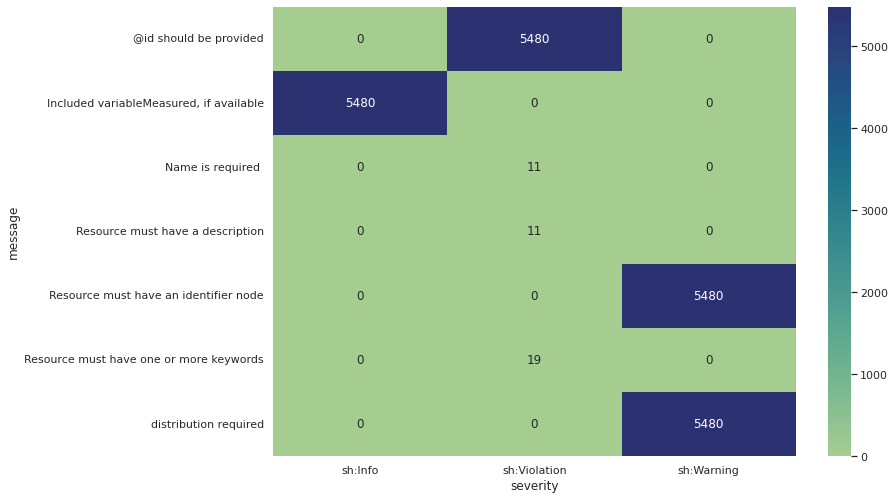

In [23]:
pdf = kg.query_as_df(sparql)
df = pdf.to_pandas()
df.style.background_gradient(cmap='Blues')

dfc = df.groupby('severity').count().reset_index().rename(columns={'path': 'Count'})
ctst = pd.crosstab(df['message'], df['severity'],  margins = False , margins_name = 'Totals')

print("Checking {} objects in {}".format(len(fns),checkPrefix ))
print(ctst)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(ctst, annot=True, fmt=".0f", cmap = sns.cm.crest)

In [24]:
# TODO export to parquet and or CSV
# df.to_parquet("./output/eco_opentopo_SHACL.parquet")
df.to_csv("./output/obistesting.csv")

## How to read

* provide a URL for each error